In [2]:
import matplotlib.pyplot as plt
import kwant
import numpy as np
import scipy
import scipy.ndimage
import scipy.linalg as la
from types import SimpleNamespace
%matplotlib inline

In [4]:
np.linspace(0.0, -0.125, 25), np.linspace(-0.0125, -0.025, 25)

(array([ 0.        , -0.00520833, -0.01041667, -0.015625  , -0.02083333,
        -0.02604167, -0.03125   , -0.03645833, -0.04166667, -0.046875  ,
        -0.05208333, -0.05729167, -0.0625    , -0.06770833, -0.07291667,
        -0.078125  , -0.08333333, -0.08854167, -0.09375   , -0.09895833,
        -0.10416667, -0.109375  , -0.11458333, -0.11979167, -0.125     ]),
 array([-0.0125    , -0.01302083, -0.01354167, -0.0140625 , -0.01458333,
        -0.01510417, -0.015625  , -0.01614583, -0.01666667, -0.0171875 ,
        -0.01770833, -0.01822917, -0.01875   , -0.01927083, -0.01979167,
        -0.0203125 , -0.02083333, -0.02135417, -0.021875  , -0.02239583,
        -0.02291667, -0.0234375 , -0.02395833, -0.02447917, -0.025     ]))

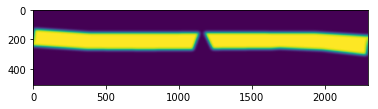

In [113]:
#designfile = '/users/tkm/kanilmaz/thesis/designfiles/hb_lower_part.png'
designfile = '/home/nefta/thesis/designfiles/qpc.png'
topgate = 1 - scipy.ndimage.imread(designfile, mode='L').T / 255
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, 10)
plt.imshow(topgate_gauss)

In [114]:
#scipy.ndimage.imread(
#    '/users/tkm/kanilmaz/thesis/designfiles/scatteringRegion_sleeves.png')

In [115]:
#scattering_region = np.ones(topgate_gauss.shape)
#scattering_region = 1 - scipy.ndimage.imread(
#    '/users/tkm/kanilmaz/thesis/designfiles/scatteringRegion_sleeves.png').T / 255)
#scattering_region = 1 - scipy.ndimage.imread(
#    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255
scattering_region = np.fliplr(1 - scipy.ndimage.imread(
    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255)

In [157]:
bilayer.vec((2, -1)), bilayer.prim_vecs

(array([8.660254037844386, 0.0]), array([[ 4.33012702,  2.5       ],
        [ 0.        ,  5.        ]]))

In [163]:
delta = 1.0 
T = delta / 2
eta = 2.5 
gamma = 0.4
at = 5
a = 0.05
#a = 0.4

bilayer =  kwant.lattice.general([(at*np.sqrt(3)/2, at*1/2), (0, at*1)],
                                 [(0, 0.0), (at*1 / (2*np.sqrt(3)), at*1/2), 
                                  (-at*1/(2*np.sqrt(3)), at*1/2), (0, 0)])
#bilayer = kwant.lattice.general([(at*1/2, at*np.sqrt(3)/2), (at*1, 0)],
#                                 [(0, 0.0), (at*1/2, at*1/(2*np.sqrt(3))), 
#                                  (0, 0), (at*1/2, -at*1/(2*np.sqrt(3)))])
#bilayer = kwant.lattice.general([(at*1/2, at*np.sqrt(3)/2), (at*1, 0)],
#                                 [(0, 0.0), (at*1/2, at*1/(2*np.sqrt(3))), 
#                                  (0, 0), (0, at/(np.sqrt(3)))])
a1, b1, a2, b2 = bilayer.sublattices
hoppings1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((1, 0), a1, b1)) 
hoppings2 = (((0, 0), a2, b2), ((0, -1), a2, b2), ((1, -1), a2, b2))

potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgate_gauss.shape[0])),
    y=(a*np.arange(topgate_gauss.shape[1])),
    z=topgate_gauss,
    kx=1,
    ky=1,
)

x = (a*np.arange(topgate_gauss.shape[0]))
y = (a*np.arange(topgate_gauss.shape[1]))
X, Y = np.meshgrid(x, y)
Z = potential(y, x)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot_wireframe(X, Y, Z, color='r')

In [164]:
def onsite(site, par):    
    topgate_potential = par.v_sg * potential(site.pos[0], site.pos[1]) 
    mu = (par.v_bg + topgate_potential) / 2 
    delta = - (topgate_potential - par.v_bg) / eta 
    # site.family in (a1, b1)
    if (site.family == a1 or site.family == b1):
        return - mu - delta 
    return -mu + delta

def onsite_lead(site, par):     
    topgate_potential = 0
    mu = (par.v_bg + topgate_potential) / 2
    delta = - ( topgate_potential - par.v_bg) / eta
    if site.family == a1 or site.family == b1:
        return - mu - delta
    return -mu  + delta

def geomShape(pos):
    #x, y = pos
    if pos[0] < 0 or pos[1] < 0:
        return False
    try:
        # rather round()?
        return scattering_region[int(pos[0] / a), int(pos[1] / a)]
    except IndexError:
        return False

def hop_intra_layer(site1, site2, par): 
    xt, yt = site1.pos 
    xs, ys = site2.pos
    return -par.t * np.exp(-0.5j * np.pi * par.B  * (xt - xs) * (yt + ys))

def hop_inter_layer(site1, site2, par): 
    return -par.gamma1 

def hop_intra_layer_lead(site1, site2, par): 
    return -par.t 

def hop_inter_layer_lead(site1, site2, par): 
    return -par.gamma1 

def leadShape1(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[0, int(y / a)]
    except IndexError:
        return False
    
def leadShape2(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[-1, int(y / a)]
    except IndexError:
        return False
    
def trs(m):
    return m.conj()

class TRIInfiniteSystem(kwant.builder.InfiniteSystem):
    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes =             super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2*n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2*n)] =             self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] =             self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes

def make_system():
    system = kwant.Builder()
    scat_width = scattering_region.shape[0]
    scat_length = scattering_region.shape[1]

    system[bilayer.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite 
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    system[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer    

    trans_sym_1 = kwant.TranslationalSymmetry(bilayer.vec((-2, 1)))
    lead_1 = kwant.Builder(trans_sym_1)
    lead_1[bilayer.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    system.attach_lead(lead_1)

    trans_sym_2 = kwant.TranslationalSymmetry(bilayer.vec((2, -1))) #?
    lead_2 = kwant.Builder(trans_sym_2)
    lead_2[bilayer.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
     

    system.attach_lead(lead_2)
    #system = system.finalized()
    system.leads = [TRIInfiniteSystem(lead, trs) for lead in system.leads]#
    return(system)

In [165]:
def family_colors(site):
    delta = 1.0 - potential(site.pos[0], site.pos[1])[0][0]
    if delta < 0.9:    
        return('black')
    else:
        return('grey')
    

In [166]:
system = make_system()
#system = system.finalized()

In [167]:
[system.sites[i].pos for i in range(len(system.sites))]

TypeError: object of type 'method' has no len()

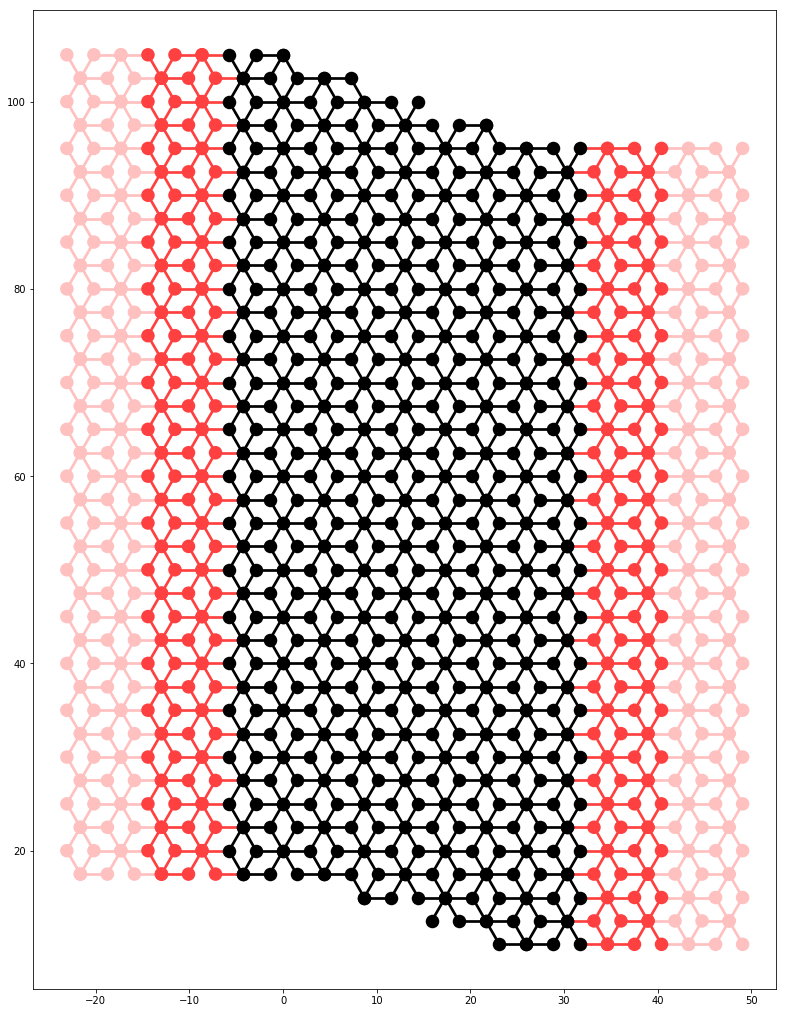

In [168]:
fig = kwant.plotter.plot(system, fig_size=(32, 18), )
#site_color=family_colors)
#fig.savefig('fullbarrier_midsize.png')

In [34]:
par = SimpleNamespace(t=1, eta=2.5, gamma1=0.4, B=0.0, v_sg=-0.6, v_bg=0.2)
ldos = kwant.ldos(system, args=[par])

TypeError: Expecting an instance of System.

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


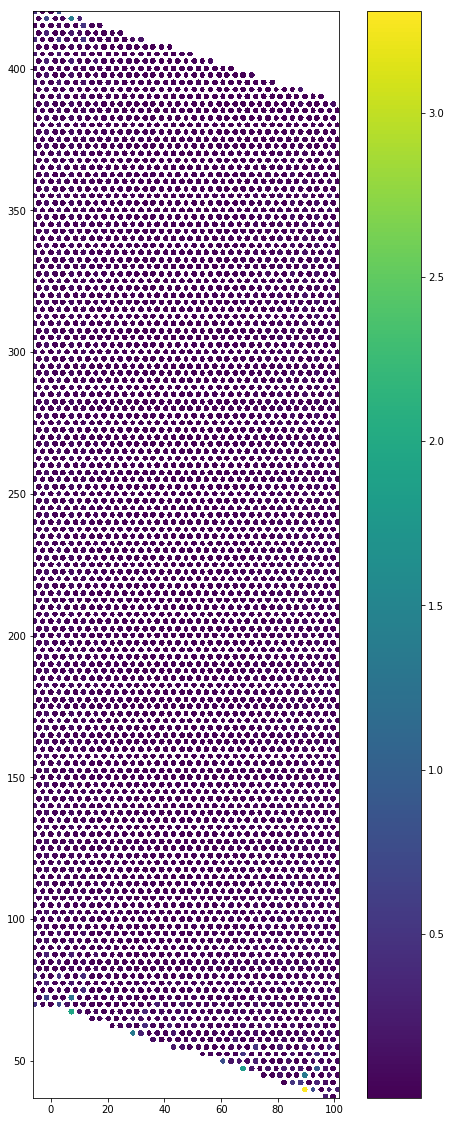

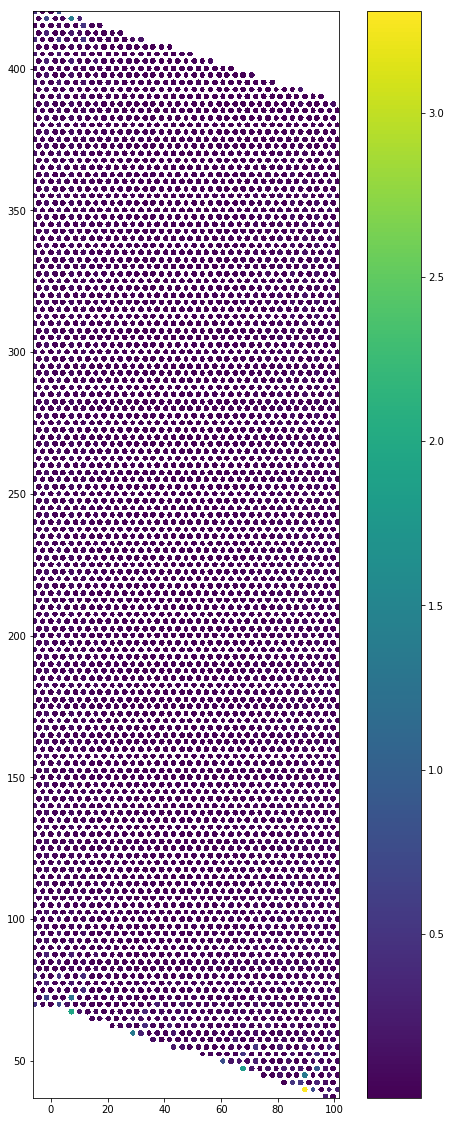

In [85]:
kwant.plotter.map(system, ldos, a=1, fig_size=(10, 20))

In [65]:
import pandas as pd
import matplotlib.patches as mpatches

In [89]:
conductance_full = pd.read_csv('/home/nefta/thesis/results/full_barrier/conductance/vbg=0.2-20171213-16:27:10/data.csv', 
            header=None, sep=' ').values[0]
conductance_qpc = pd.read_csv('/home/nefta/thesis/results/qpc/conductance/vbg=0.2-20171213-16:37:29/data.csv', 
            header=None, sep=' ').values[0]

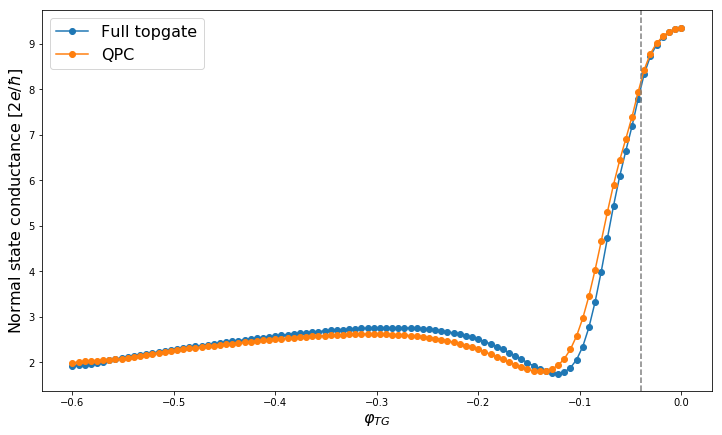

In [96]:
phi_tg = np.linspace(-0.6, 0.0, 100)
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(phi_tg,conductance_full, marker='o', label='Full topgate')
ax.plot(phi_tg,conductance_qpc, marker='o', label='QPC')
ax.set_ylabel(r'Normal state conductance [$2e/\hbar$]', fontsize=16,)
ax.set_xlabel(r'$\varphi_{TG}$', fontsize=16)
ax.axvline(-0.04, linestyle='dashed', color='grey')
ax.legend(fontsize=16)
#fig.text(1, 1, 'gapped')
fig.savefig('/home/nefta/thesis/results/conductance_qpc_full_barrier.png')